<a href="https://colab.research.google.com/github/ikramMc/PFE/blob/main/data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Synthetic data**

In [ ]:
import requests
import os
from pathlib import Path
import time
import json

hyperbolic_API_KEY = os.getenv("Hyberbolic_key")
# 🔧 Model and endpoint
MODEL_NAME = "deepseek-ai/DeepSeek-V3"
API_URL = "https://api.hyperbolic.xyz/v1/chat/completions"


# 🧾 Instruction prompt
system_prompt = """You are an offensive security expert with deep understanding of ethical hacking. Turn this raw text to pairs of (instruction-answer) that help to assess pentesters knowledge and skills on offensive security.
Instructions must never explicitly reference the text, figure or table. Instructions must be self-contained and with different levels of complexity. Only use concepts from the provided text.
Make answers detailed if details exist (e.g., examples), and diversify more the type of questions (use verbs, instructions, scenario-based questions, WH questions, conversational mode).

Return the output in this JSON format with this structure:
[
  {
    "instruction": "",
    "answer": ""
  },
  ...
]generate the maximum of pairs ,no limit"""

headers = {
    "Authorization": f"Bearer {hyperbolic_API_KEY}",
    "Content-Type": "application/json"
}

# 📄 Load already processed files
processed_file = Path("processed_for_generation (2).txt")
processed_files = set()

if processed_file.exists():
    with open(processed_file, "r", encoding="utf-8") as f:
        processed_files = set(line.strip() for line in f.readlines())

# 📂 Load file names from group1.txt
group1_file = Path("group1.txt")
if not group1_file.exists():
    print("❌ 'group1.txt' not found.")
    exit()

with open(group1_file, "r", encoding="utf-8") as f:
    group1_files = [line.strip() for line in f.readlines() if line.strip()]

counter = 0
for filename in group1_files:
    md_file = Path(filename)
    if not md_file.exists():
        print(f"⚠️ File {filename} not found, skipping.")
        continue
    if md_file.name in processed_files:
        print(f"⏩ Skipping already processed file: {md_file.name}")
        continue

    print(f"📄 Processing {md_file.name}")
    with open(md_file, "r", encoding="utf-8") as f:
        writeup_content = f.read()

    payload = {
        "model": MODEL_NAME,
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": writeup_content}
        ],
        "temperature": 0.7,
        "max_tokens": 40960,
        "top_p": 0.9
    }

    try:
        response = requests.post(API_URL, headers=headers, json=payload)
        response.raise_for_status()
        result = response.json()
        conversation = result["choices"][0]["message"]["content"]

        # Count number of instruction-answer pairs
        try:
            count = conversation.count('"instruction":')
            print(f"🔢 {count} instruction-answer pairs generated.")
        except Exception:
            print("⚠️ Failed to count instruction-answer pairs.")
            print(conversation)

        # Save result
        output_path = Path(f"QA_{md_file.stem}.md")
        with open(output_path, "w", encoding="utf-8") as out:
            out.write(conversation)

        print(f"✅ QA saved to {output_path.name}")
        counter += 1

        # Mark as processed
        with open(processed_file, "a", encoding="utf-8") as f:
            f.write(md_file.name + "\n")

        if counter % 2 == 0:
            print("⏳ Sleeping for 10 seconds...")
            time.sleep(2)

    except Exception as e:
        print(f"❌ Error processing {md_file.name}: {e}")


**POST-processing, deduplication, check similarity with source files**

**check similarity with source**

In [ ]:
#first turn instruction and resposne columns to chatML format
import pandas as pd
import json

def generate_conversations(df):
    conversations = []
    for _, row in df.iterrows():
        if pd.isna(row['instruction']) or pd.isna(row['answer']):
            conversations.append(None)
            continue
        convo = [
            {"role": "user", "content": str(row['instruction']).strip()},
            {"role": "assistant", "content": str(row['answer']).strip()}
        ]
        conversations.append(convo)
    return conversations

if __name__ == "__main__":
    # 📂 Input CSV path
    csv_path = "instruction_answer_pairs_with_dup_no_sim_clean_with_source_file.csv"

    try:
        # Charger le fichier CSV
        df = pd.read_csv(csv_path)

        if not all(col in df.columns for col in ['instruction', 'answer']):
            raise ValueError("CSV must contain 'instruction' and 'answer' columns.")

        # Générer les conversations et ajouter une nouvelle colonne
        df['conversations'] = generate_conversations(df)

        # Convert list of dicts to JSON string for saving
        df['conversations'] = df['conversations'].apply(lambda x: json.dumps(x) if x is not None else "")

        # Sauvegarder dans le même fichier (ou un autre si tu veux garder l’original)
        df.to_csv(csv_path, index=False)
        print(f"✅ Conversations saved back to: {csv_path}")

    except Exception as e:
        print(f"❌ Error: {str(e)}")


In [ ]:
#For every conversations entry in a CSV file, the script finds the most similar text chunk in its associated .md documentation (based on sentence embeddings) and saves the result to a new CSV.
import os
import pandas as pd
from sentence_transformers import SentenceTransformer, util
import torch

# Configuration
CSV_PATH = "instruction_answer_pairs_with_dup_no_sim_clean_with_source_file.csv"  # Dataset with 'conversations' and 'source_file'
MD_DIR = "./"                          # Folder with .md files
CHUNK_SIZE =2000                      # Characters per chunk
MODEL_NAME = "intfloat/multilingual-e5-large-instruct"  # Sentence embedding model
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Load dataset and model
df = pd.read_csv(CSV_PATH)
model = SentenceTransformer(MODEL_NAME, device=DEVICE)

# Helper: Split large text into chunks
def chunk_text(text, chunk_size=2000):
    return [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]

# Prepare results list
results = []

# Group dataset by source_file (excluding UNKNOWN)
grouped = df[df['source_file'] != "UNKNOWN"].groupby('source_file')

# Process each source file group
for source_file, group_df in grouped:
    source_file_clean = source_file.replace("QA_", "")
    md_path = os.path.join(MD_DIR, source_file_clean)

    if not os.path.isfile(md_path):
        print(f"⚠️ File not found: {md_path}")
        continue

    # Read and chunk .md file
    with open(md_path, 'r', encoding='utf-8') as f:
        content = f.read()
    chunks = chunk_text(content, chunk_size=CHUNK_SIZE)
    chunk_embeddings = model.encode(chunks, convert_to_tensor=True)

    # Batch encode conversations
    conversations = group_df['conversations'].tolist()
    conv_embeddings = model.encode(conversations, convert_to_tensor=True)

    # Compute cosine similarity
    sim_matrix = util.cos_sim(conv_embeddings, chunk_embeddings)
    max_scores, max_idxs = sim_matrix.max(dim=1)

    # Store results with conversation included
    for idx, row_idx in enumerate(group_df.index):
        results.append({
            "index": row_idx,
            "source_file": source_file,
            "conversations": df.at[row_idx, "conversations"],
            "best_chunk": chunks[max_idxs[idx].item()],
            "similarity": max_scores[idx].item()
        })

# Handle UNKNOWN source_file entries
unknown_rows = df[df['source_file'] == "UNKNOWN"]
for _, row in unknown_rows.iterrows():
    results.append({
        "index": row.name,
        "source_file": row['source_file'],
        "conversations": row['conversations'],
        "best_chunk": "",
        "similarity": 0.0
    })

# Convert to DataFrame, sort by original index, save
results_df = pd.DataFrame(results).sort_values(by="index")
results_df.to_csv("conversation_best_chunks.csv", index=False)
print("✅ Results saved to 'conversation_best_chunks.csv'")


In [ ]:
import pandas as pd

# Charger les deux fichiers
original_df = pd.read_csv("instruction_answer_pairs_with_dup_no_sim_clean_with_source_file.csv")
similarity_df = pd.read_csv("conversation_best_chunks.csv")

# Fusionner les deux fichiers sur l'index (ou la colonne 'index' si elle est présente)
merged_df = original_df.copy()
merged_df["similarity"] = similarity_df["similarity"]

# Garder uniquement les lignes avec une similarité >= 0.87
filtered_df = merged_df[(merged_df["similarity"] >= 0.87) | (merged_df['source_file'] == "UNKNOWN")]

# Supprimer la colonne de similarité si elle n'est plus nécessaire
filtered_df = filtered_df.drop(columns=["similarity"])

# Sauvegarder le nouveau fichier nettoyé
filtered_df.to_csv("instruction_answer_pairs_filtered.csv", index=False)

print(f"✅ Fichier filtré sauvegardé avec {len(filtered_df)} lignes.")


**deduplication**

In [ ]:
%%capture
!pip install faiss-cpu
# Install libraries
!pip install -q datasets transformers sentence_transformers faiss-gpu-cu12
!pip install numpy --upgrade
!pip install pandas --upgrade --force-reinstall

In [ ]:
import pandas as pd
dataset=pd.read_csv("instruction_answer_pairs_with_dup_sim_clean_with_source_file.csv")

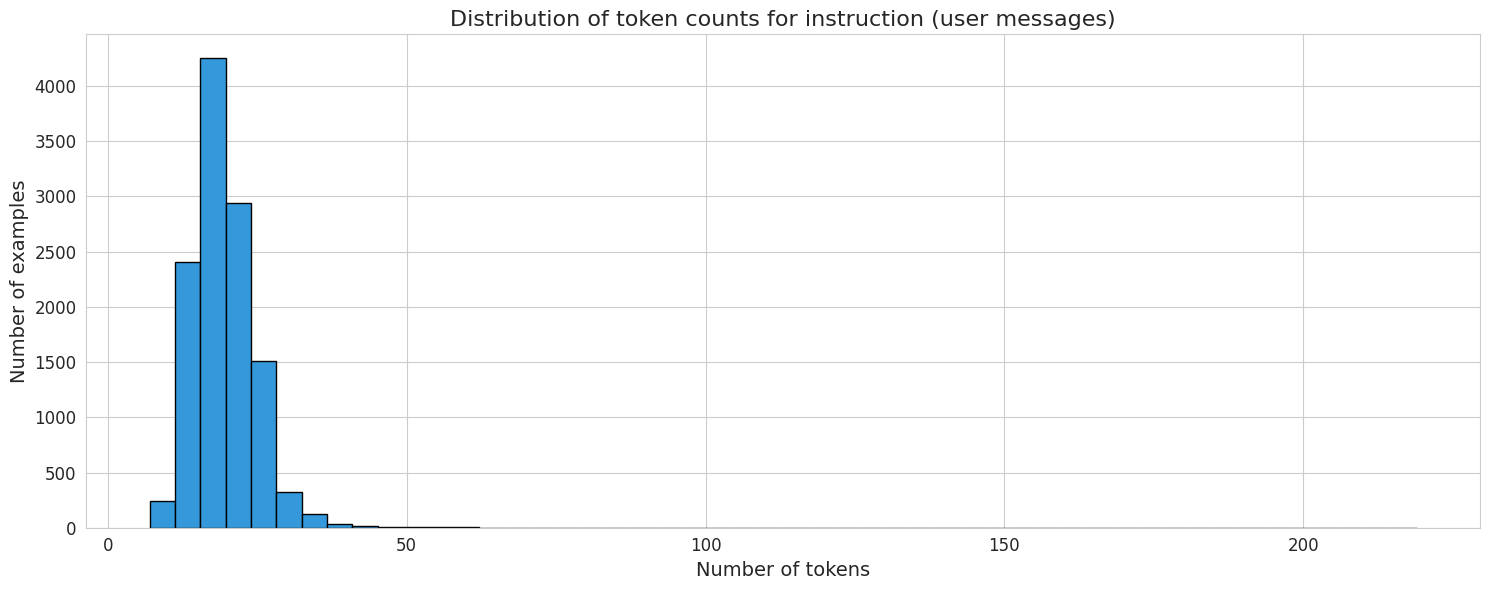

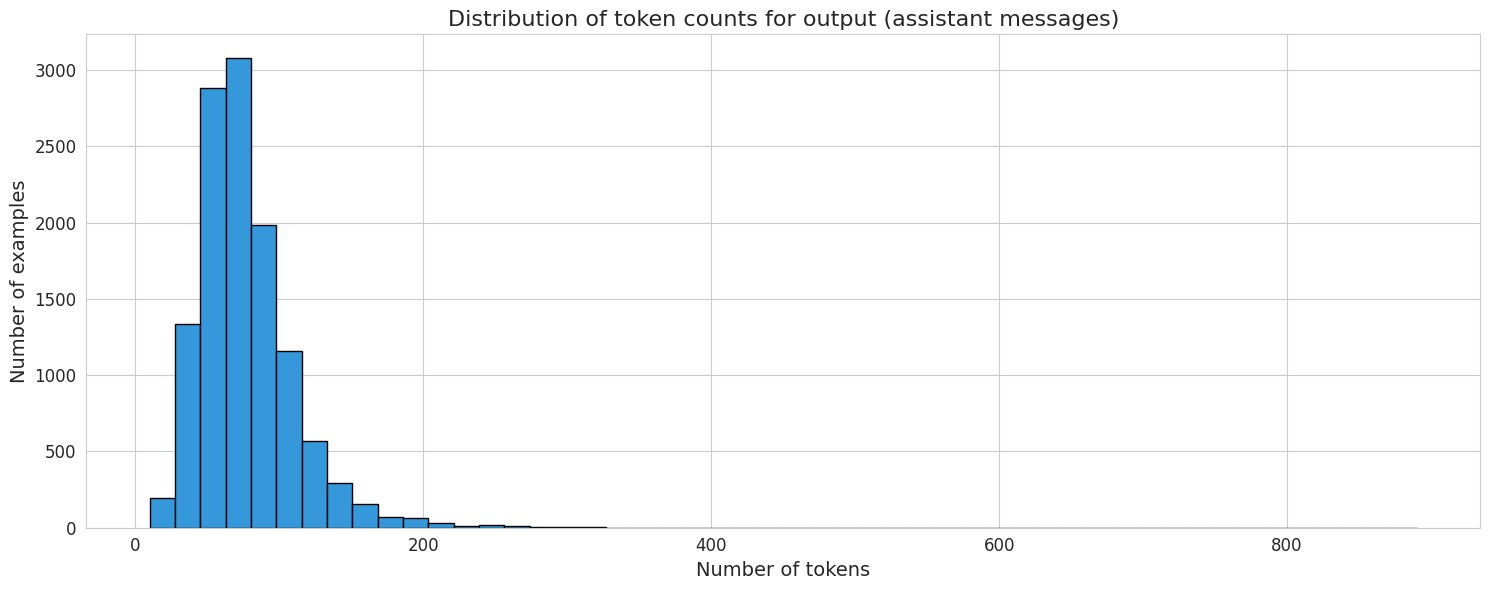

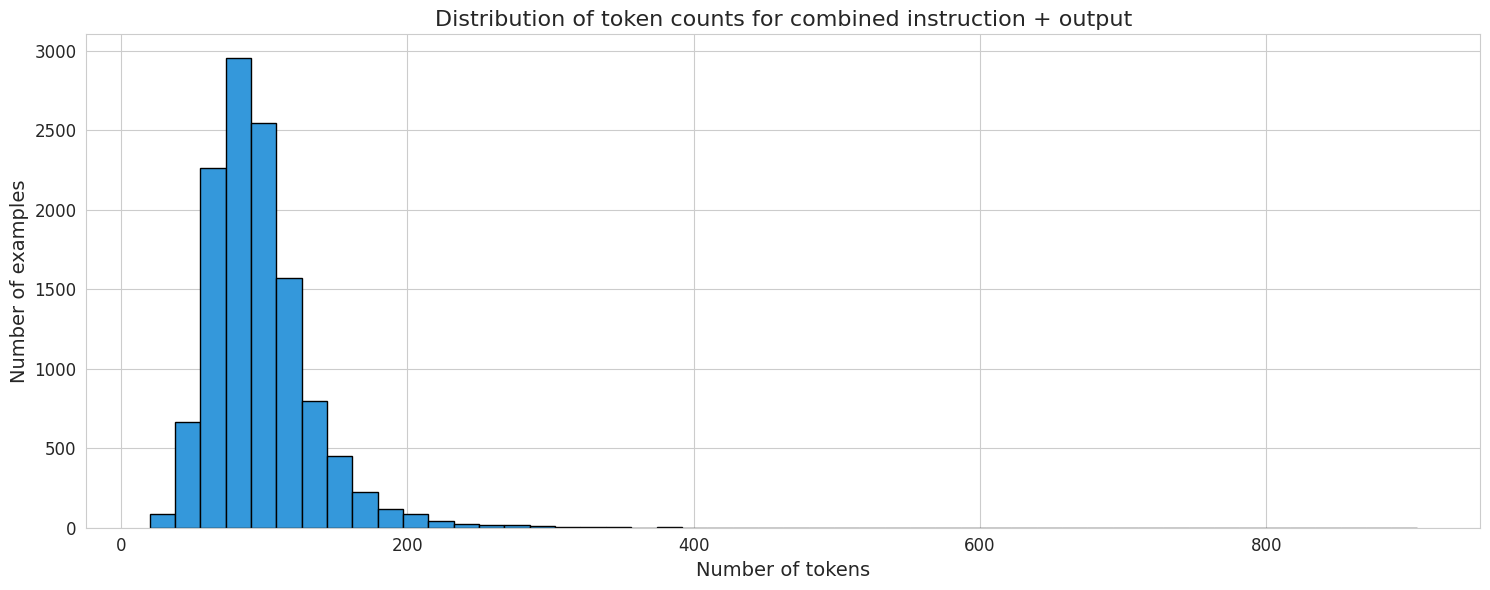

In [ ]:
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import ast  # To safely parse stringified lists of dicts
import os
token=os.getenv("HF_TOKEN")
# 1. Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.3", token=token

# 2. Initialize token count lists
instruction_token_counts = []
output_token_counts = []
combined_token_counts = []

# 3. Loop through each conversation
for example in dataset.to_dict('records'):
    try:
        # Parse the stringified list of dictionaries
        conversation = ast.literal_eval(example["conversations"])
        user_parts = [msg["content"] for msg in conversation if msg["role"] == "user"]
        assistant_parts = [msg["content"] for msg in conversation if msg["role"] == "assistant"]

        # Join multiple user/assistant parts if any
        instruction_text = " ".join(user_parts)
        output_text = " ".join(assistant_parts)

        # Tokenize and count
        instruction_tokens = len(tokenizer.tokenize(instruction_text))
        output_tokens = len(tokenizer.tokenize(output_text))
        combined_tokens = instruction_tokens + output_tokens

        # Append to lists
        instruction_token_counts.append(instruction_tokens)
        output_token_counts.append(output_tokens)
        combined_token_counts.append(combined_tokens)

    except Exception as e:
        print(f"Error processing row: {e}")
        continue

# 4. Plotting helper
def plot_distribution(token_counts, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 6))
    plt.hist(token_counts, bins=50, color='#3498db', edgecolor='black')
    plt.title(title, fontsize=16)
    plt.xlabel("Number of tokens", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# 5. Plot the token distributions
plot_distribution(instruction_token_counts, "Distribution of token counts for instruction (user messages)")
plot_distribution(output_token_counts, "Distribution of token counts for output (assistant messages)")
plot_distribution(combined_token_counts, "Distribution of token counts for combined instruction + output")


In [ ]:
import pandas as pd
import numpy as np
import ast
from sentence_transformers import SentenceTransformer
import faiss
from tqdm.auto import tqdm

def extract_assistant_responses(conversations):
    assistant_texts = []
    for row in conversations:
        conversation = ast.literal_eval(row) if isinstance(row, str) else row
        assistant_turns = [turn['content'] for turn in conversation if turn['role'] == 'assistant']
        assistant_texts.append(" ".join(assistant_turns))
    return assistant_texts

def deduplicate_dataset(df, model_name: str, threshold: float):
    # Extract assistant responses
    outputs = extract_assistant_responses(df['conversations'])

    # Encode responses
    sentence_model = SentenceTransformer(model_name)
    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

    # Build FAISS index
    index = faiss.IndexFlatIP(dimension)
    index.add(normalized_embeddings)

    # Search for near-duplicates
    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = set()
    duplicate_indices = set()
    duplicate_records = []
    duplicate_pairs = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        if D[i, 1] >= threshold:
            nearest_neighbor = I[i, 1]
            if i not in duplicate_indices and nearest_neighbor not in duplicate_indices:
                # Save one of the duplicates
                duplicate_indices.add(nearest_neighbor)
                duplicate_records.append(df.iloc[nearest_neighbor])
                # Save both items with similarity score
                duplicate_pairs.append({
                    'item_1': df.iloc[i]['conversations'],
                    'item_2': df.iloc[nearest_neighbor]['conversations'],
                    'similarity': D[i, 1]
                })
        else:
            to_keep.add(i)

    # Create deduplicated DataFrame
    deduped_df = df.drop(index=duplicate_indices).reset_index(drop=True)

    # Save results
    pd.DataFrame(duplicate_records).to_csv("duplicates.csv", index=False)
    pd.DataFrame(duplicate_pairs).to_csv("duplicate_pairs.csv", index=False)
    deduped_df.to_csv("deduplicated_dataset.csv", index=False)

    return deduped_df

merged_df =dataset

# Deduplicate the merged dataset
deduplicated_df = deduplicate_dataset(merged_df, "intfloat/multilingual-e5-large-instruct", 0.96)


In [ ]:
import pandas as pd
import numpy as np
import ast
from sentence_transformers import SentenceTransformer
import faiss
from tqdm.auto import tqdm

def extract_assistant_responses(conversations):
    assistant_texts = []
    for row in conversations:
        conversation = ast.literal_eval(row) if isinstance(row, str) else row
        assistant_turns = [turn['content'] for turn in conversation if turn['role'] == 'assistant']
        assistant_texts.append(" ".join(assistant_turns))
    return assistant_texts

def deduplicate_dataset(df, model_name: str, threshold: float):
    # Extract assistant responses
    outputs = extract_assistant_responses(df['conversations'])

    # Encode responses
    sentence_model = SentenceTransformer(model_name)
    print("Converting text to embeddings...")
    embeddings = sentence_model.encode(outputs, show_progress_bar=True)
    dimension = embeddings.shape[1]
    normalized_embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

    # Build FAISS index
    index = faiss.IndexFlatIP(dimension)
    index.add(normalized_embeddings)

    # Search for near-duplicates
    print("Filtering out near-duplicates...")
    D, I = index.search(normalized_embeddings, k=2)
    to_keep = set()
    duplicate_indices = set()
    duplicate_records = []
    duplicate_pairs = []

    for i in tqdm(range(len(embeddings)), desc="Filtering"):
        if D[i, 1] >= threshold:
            nearest_neighbor = I[i, 1]
            if i not in duplicate_indices and nearest_neighbor not in duplicate_indices:
                # Save one of the duplicates
                duplicate_indices.add(nearest_neighbor)
                duplicate_records.append(df.iloc[nearest_neighbor])
                # Save both items with similarity score
                duplicate_pairs.append({
                    'item_1': df.iloc[i]['conversations'],
                    'item_2': df.iloc[nearest_neighbor]['conversations'],
                    'similarity': D[i, 1]
                })
        else:
            to_keep.add(i)

    # Create deduplicated DataFrame
    deduped_df = df.drop(index=duplicate_indices).reset_index(drop=True)

    # Save results
    pd.DataFrame(duplicate_records).to_csv("duplicates.csv", index=False)
    pd.DataFrame(duplicate_pairs).to_csv("duplicate_pairs.csv", index=False)
    deduped_df.to_csv("deduplicated_dataset.csv", index=False)

    return deduped_df

merged_df =dataset

# Deduplicate the merged dataset
deduplicated_df = deduplicate_dataset(merged_df, "intfloat/multilingual-e5-large-instruct", 0.96)


Converting text to embeddings...


Batches:   0%|          | 0/372 [00:00<?, ?it/s]

Filtering out near-duplicates...


Filtering:   0%|          | 0/11882 [00:00<?, ?it/s]

**manually fix samples with refrences to code , context,file ,figure....**

In [ ]:
import pandas as pd
import re

# Load your dataset
df = pd.read_csv("deduplicated_dataset.csv")

# Define suspicious patterns
reference_patterns = [
    r"\b(as )?(shown|mentioned|explained|discussed) (above|below|earlier|before|in the file)?\b",
    r"\bsee (the )?(snippet|figure|function|context|example|section|file|code)\b",
    r"\bthe (snippet|figure|function|example|section|file|code)\b",
    r"\b(previous|following|above|below)(snippet|figure|function|context|example|section|file|code)\b",
    r"\bthis (snippet|figure|function|context|example|section|file|code)\b",
    r"\bgiven (snippet|figure|function|context|example|section|file|code)\b",

]

# Combine into one regex pattern
combined_pattern = re.compile("|".join(reference_patterns), re.IGNORECASE)

# Apply heuristic
df["dangling_reference"] = df["instruction"].apply(lambda x: bool(combined_pattern.search(str(x))))

# View problematic instructions
suspect_instructions = df[df["dangling_reference"] == True]

# Save for review
suspect_instructions.to_csv("instructions_with_potential_references.csv", index=False)

print(f"⚠️ Found {len(suspect_instructions)} instructions that may contain unresolved references.")


⚠️ Found 79 instructions that may contain unresolved references.


In [ ]:
import pandas as pd

# Load the full dataset
df_full = pd.read_csv("deduplicated_dataset.csv")

# Load the potential reference samples (before manual editing)
suspect_df = pd.read_csv("instructions_with_potential_references.csv")

# Create a matching key using 'instruction' + 'answer' to ensure uniqueness
df_full["key"] = df_full["instruction"].astype(str) + "||" + df_full["answer"].astype(str)
suspect_df["key"] = suspect_df["instruction"].astype(str) + "||" + suspect_df["answer"].astype(str)

# Filter out the suspect instructions from the full dataset
df_cleaned = df_full[~df_full["key"].isin(suspect_df["key"])].drop(columns=["key"])

# Save the cleaned dataset
df_cleaned.to_csv("instruction_answer_pairs_filtered_cleaned.csv", index=False)

print(f"✅ Removed {len(df_full) - len(df_cleaned)} suspect samples.")
print(f"🧼 Cleaned file saved as 'instruction_answer_pairs_filtered_cleaned.csv' with {len(df_cleaned)} rows.")


✅ Removed 79 suspect samples.
🧼 Cleaned file saved as 'instruction_answer_pairs_filtered_cleaned.csv' with 11423 rows.


In [ ]:
import pandas as pd

# Load the cleaned full dataset (no suspect samples)
df_cleaned = pd.read_csv("instruction_answer_pairs_filtered_cleaned.csv")

# Load the manually processed suspect samples
corrected_df = pd.read_csv("instructions_with_potential_references - processed.csv")

# Only keep the rows NOT marked as 'delete' in the 6th column
# Replace 'action' with the actual name of your column if needed
valid_corrections = corrected_df
# Merge back the corrected rows
merged_df = pd.concat([df_cleaned, valid_corrections], ignore_index=True)

# Save the final dataset
merged_df.to_csv("instruction_answer_pairs_final.csv", index=False)

print(f"✅ Final dataset saved with {len(merged_df)} rows, including manually corrected samples.")


✅ Final dataset saved with 11483 rows, including manually corrected samples.


# **Manual data**

**convert Manual CTF conv to ChatML format**

In [3]:
%%capture
!pip install datasets

In [1]:
import pandas as pd
from datasets import Dataset
from pprint import pprint
import json

# Load the CSV file
df = pd.read_csv('CTF Dataset - pairs.csv')  # Replace with your actual file path

# Forward fill NaN values in the 'report' column to ensure continuity
df['report'] = df['report'].ffill()

# Initialize dataset list
dataset = []

# Group conversations by report
for report, group in df.groupby('report'):
    conversation = []

    # Iterate over each row in the grouped data
    for _, row in group.iterrows():
        # Skip incomplete pairs (missing either input or output)
        if pd.isna(row['Input']) or pd.isna(row['output']) or not row['Input'].strip() or not row['output'].strip():
            continue

        # Add human and assistant messages
        conversation.append({"role": "user", "content": row['Input']})
        conversation.append({"role": "assistant", "content": row['output']})

    if conversation:  # Only add non-empty conversations
        dataset.append({"report": report, "conversations": conversation})

# Convert to Hugging Face Dataset format
hf_dataset = Dataset.from_dict({
    'report': [entry['report'] for entry in dataset],
    'conversations': [entry['conversations'] for entry in dataset]
})

# Show one example
#print("Example conversation for one report:")
#pprint(hf_dataset['conversations'][0])

# Optional: Save to CSV (each conversation as a JSON string)
df_to_save = pd.DataFrame({
    'report': [entry['report'] for entry in dataset],
    'conversations': [json.dumps(entry['conversations'], ensure_ascii=False) for entry in dataset]
})
df_to_save.to_csv('all_report_conversations.csv', index=False)


# **Gather data from hacktricks , CTF and CEH then split train-test-val**

In [ ]:
import pandas as pd
import json
from datasets import Dataset, concatenate_datasets
from pprint import pprint

def load_instruction_answer(csv_path, source_name):
    df = pd.read_csv(csv_path)
    if not all(col in df.columns for col in ['instruction', 'answer']):
        raise ValueError(f"{csv_path} must contain 'instruction' and 'answer' columns.")

    conversation_dataset = []
    for _, row in df.iterrows():
        if pd.isna(row['instruction']) or pd.isna(row['answer']):
            continue

        conversation = [
            {"role": "user", "content": str(row['instruction']).strip()},
            {"role": "assistant", "content": str(row['answer']).strip()}
        ]
        conversation_dataset.append({
            "conversations": conversation,
            "source": source_name
        })

    return Dataset.from_dict({
        'conversations': [entry['conversations'] for entry in conversation_dataset],
        'source': [entry['source'] for entry in conversation_dataset]
    })


def load_question_answer(csv_path, source_name):
    df = pd.read_csv(csv_path)
    if not all(col in df.columns for col in ['question', 'answer']):
        raise ValueError(f"{csv_path} must contain 'question' and 'answer' columns.")

    conversation_dataset = []
    for _, row in df.iterrows():
        if pd.isna(row['question']) or pd.isna(row['answer']):
            continue

        conversation = [
            {"role": "user", "content": str(row['question']).strip()},
            {"role": "assistant", "content": str(row['answer']).strip()}
        ]
        conversation_dataset.append({
            "conversations": conversation,
            "source": source_name
        })

    return Dataset.from_dict({
        'conversations': [entry['conversations'] for entry in conversation_dataset],
        'source': [entry['source'] for entry in conversation_dataset]
    })


def load_conversation_direct(csv_path, source_name):
    df = pd.read_csv(csv_path)
    if 'conversations' not in df.columns:
        raise ValueError(f"{csv_path} must contain 'conversations' column.")

    conversation_dataset = []
    for _, row in df.iterrows():
        if pd.isna(row['conversations']):
            continue

        try:
            conv_list = json.loads(row['conversations'])
        except json.JSONDecodeError:
            raise ValueError(f"Invalid JSON format in 'conversations': {row['conversations']}")

        conversation_dataset.append({
            "conversations": conv_list,
            "source": source_name
        })

    return Dataset.from_dict({
        'conversations': [entry['conversations'] for entry in conversation_dataset],
        'source': [entry['source'] for entry in conversation_dataset]
    })


if __name__ == "__main__":
    # Définir les chemins vers les fichiers
    instruction_answer_csv = "instruction_answer_pairs_final.csv"  # HackTricks
    question_answer_csv = "CEH.csv"                                # CEH
    conversation_direct_csv ="all_report_conversations.csv"                        # CTF (déjà formaté)

    try:
        # Charger les jeux de données avec le nom de la source
        dataset1 = load_instruction_answer(instruction_answer_csv, "HackTricks")
        dataset2 = load_question_answer(question_answer_csv, "CEH")
        dataset3 = load_conversation_direct(conversation_direct_csv, "CTF-man")

        # Fusionner les datasets
        full_dataset = concatenate_datasets([dataset1, dataset2, dataset3])

        # Mélanger les données
        full_dataset = full_dataset.shuffle(seed=3407)

        # Afficher les infos
        print(f"✅ Full dataset created with {len(full_dataset)} conversations\n")
        print("🧪 Example conversation:")
        pprint(full_dataset[0]['conversations'])
        print(f"📄 Source: {full_dataset[0]['source']}")

        # Sauvegarder sous CSV
        df = full_dataset.to_pandas()
        df.to_csv("final_conversation_dataset.csv", index=False)
        print("💾 Dataset saved to final_conversation_dataset.csv")

    except Exception as e:
        print(f"❌ Error: {str(e)}")


/usr/local/lib/python3.11/dist-packages/datasets/table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
/usr/local/lib/python3.11/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


✅ Full dataset created with 11844 conversations

🧪 Example conversation:
[{'content': 'Explain the process of manually decoding and modifying a '
             'gRPC-Web payload using the gRPC Coder tool.',
  'role': 'user'},
 {'content': 'To manually decode and modify a gRPC-Web payload: \\n1. Decode '
             'the base64 payload using `grpc-coder.py` with the `--decode` '
             'flag and output it in protoscope format.\\n2. Edit the decoded '
             'content in a text editor (e.g., `nano`) to manipulate fields '
             'like strings, integers, or inject payloads (e.g., XSS).\\n3. '
             'Re-encode the modified content using `protoscope` and '
             '`grpc-coder.py` with the `--encode` flag.\\n4. Use the resulting '
             'base64 payload in tools like Burp Suite for testing.',
  'role': 'assistant'}]
📄 Source: HackTricks
💾 Dataset saved to final_conversation_dataset.csv


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Charger le CSV final
df = pd.read_csv("final_conversation_dataset.csv")

# Listes pour stocker les splits
train_parts = []
val_parts = []
test_parts = []

# Séparer pour chaque source individuellement
for source in df["source"].unique():
    source_df = df[df["source"] == source]

    # D'abord séparer train (90%) et temp (10%)
    train_df, temp_df = train_test_split(
        source_df, test_size=0.10, random_state=42, shuffle=True
    )

    # Ensuite séparer temp en val (5%) et test (5%)
    val_df, test_df = train_test_split(
        temp_df, test_size=0.5, random_state=42, shuffle=True
    )

    # Ajouter aux listes
    train_parts.append(train_df)
    val_parts.append(val_df)
    test_parts.append(test_df)

# Concaténer les parties finales
train_final = pd.concat(train_parts).sample(frac=1, random_state=42).reset_index(drop=True)
val_final = pd.concat(val_parts).sample(frac=1, random_state=42).reset_index(drop=True)
test_final = pd.concat(test_parts).sample(frac=1, random_state=42).reset_index(drop=True)

# Sauvegarder les fichiers
train_final.to_csv("train.csv", index=False)
val_final.to_csv("val.csv", index=False)
test_final.to_csv("test.csv", index=False)

print("✅ Datasets saved:")
print(f"🔹 Train: {len(train_final)} examples")
print(f"🔹 Validation: {len(val_final)} examples")
print(f"🔹 Test: {len(test_final)} examples")


✅ Datasets saved:
🔹 Train: 10658 examples
🔹 Validation: 592 examples
🔹 Test: 594 examples


In [ ]:
import pandas as pd

# Charger les datasets
train_df = pd.read_csv("train.csv")
val_df = pd.read_csv("val.csv")
test_df = pd.read_csv("test.csv")

# Fonction utilitaire
def count_sources(df, name):
    print(f"\n📊 Répartition dans {name}:")
    print(df["source"].value_counts())

# Afficher les répartitions
count_sources(train_df, "Train")
count_sources(val_df, "Validation")
count_sources(test_df, "Test")



📊 Répartition dans Train:
source
HackTricks    10280
CEH             296
CTF-man          82
Name: count, dtype: int64

📊 Répartition dans Validation:
source
HackTricks    571
CEH            16
CTF-man         5
Name: count, dtype: int64

📊 Répartition dans Test:
source
HackTricks    572
CEH            17
CTF-man         5
Name: count, dtype: int64


In [ ]:
import pandas as pd
import re

def fix_missing_commas(text):
    # Remplace les cas où deux dictionnaires sont collés sans virgule
    return re.sub(r'}\s*{', '}, {', str(text))

# Liste des fichiers à corriger
files = ["train.csv", "val.csv", "test.csv"]
column_name = "conversations"

for file in files:
    try:
        df = pd.read_csv(file)
        if column_name in df.columns:
            df[column_name] = df[column_name].astype(str).apply(fix_missing_commas)
            df.to_csv(file, index=False)
            print(f"✅ {file} corrigé et sauvegardé.")
        else:
            print(f"❌ Colonne '{column_name}' non trouvée dans {file}")
    except Exception as e:
        print(f"❌ Erreur lors du traitement de {file} : {e}")


✅ train.csv corrigé et sauvegardé.
✅ val.csv corrigé et sauvegardé.
✅ test.csv corrigé et sauvegardé.


In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install transformers==4.51.3
    !pip install --no-deps unsloth

In [ ]:
from unsloth import FastLanguageModel
import pandas as pd
import ast
from transformers import AutoTokenizer

# Load Mistral tokenizer
tokenizer = AutoTokenizer.from_pretrained("unsloth/mistral-7b-instruct-v0.3-bnb-4bit",load_in_4bit = True)



🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


tokenizer_config.json:   0%|          | 0.00/141k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/587k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

In [ ]:
import pandas as pd
import json
import ast
from transformers import AutoTokenizer

# Liste des fichiers à traiter
files = ["train.csv", "val.csv", "test.csv"]
column_name = "conversations"


# Paramètres
max_tokens = 4500
round_overlap = 1  # Nombre de tours à chevaucher

for file in files:
    print(f"🔄 Traitement de {file}")
    df = pd.read_csv(file)
    processed_rows = []

    for idx, row in df.iterrows():
        try:
            raw_data = row[column_name]

            # Parse JSON ou Python literal
            try:
                messages = json.loads(raw_data)
            except json.JSONDecodeError:
                messages = ast.literal_eval(raw_data)

            if not messages or messages[0].get("role") != "user":
                continue

            # Nombre de paires user/assistant
            count_pairs = 0
            for i in range(0, len(messages) - 1, 2):
                if messages[i].get("role") == "user" and messages[i + 1].get("role") == "assistant":
                    count_pairs += 1

            if count_pairs < 2:
                # 💡 Si moins de 2 paires : garder tel quel
                new_row = row.copy()
                new_row[column_name] = json.dumps(messages, ensure_ascii=False)
                processed_rows.append(new_row)
                continue

            # Sinon : découpage en sous-conversations
            i = 0
            while i < len(messages) - 1:
                subconv = []
                tokens = 0
                start_i = i

                while i < len(messages) - 1:
                    user_msg = messages[i]
                    assistant_msg = messages[i + 1]

                    if user_msg["role"] != "user" or assistant_msg["role"] != "assistant":
                        i += 1
                        continue

                    pair_tokens = len(tokenizer.encode(user_msg["content"], add_special_tokens=False)) + \
                                  len(tokenizer.encode(assistant_msg["content"], add_special_tokens=False))

                    if tokens + pair_tokens <= max_tokens:
                        subconv.extend([user_msg, assistant_msg])
                        tokens += pair_tokens
                        i += 2
                    else:
                        break

                if subconv:
                    new_row = row.copy()
                    new_row[column_name] = json.dumps(subconv, ensure_ascii=False)
                    processed_rows.append(new_row)

                i = max(i - round_overlap * 2, start_i + 2)

        except Exception as e:
            print(f"❌ Erreur ligne {idx} dans {file}: {e}")
            continue

    # Sauvegarde finale
    output_file = file.replace(".csv", "_with_sub_conversations.csv")
    pd.DataFrame(processed_rows).to_csv(output_file, index=False)
    print(f"✅ Sauvegardé dans {output_file}")


🔄 Traitement de train.csv
✅ Sauvegardé dans train_with_sub_conversations.csv
🔄 Traitement de val.csv
✅ Sauvegardé dans val_with_sub_conversations.csv
🔄 Traitement de test.csv
✅ Sauvegardé dans test_with_sub_conversations.csv


In [ ]:
import pandas as pd

# Charger les datasets
train_df = pd.read_csv("train_with_sub_conversations.csv")
val_df = pd.read_csv("val_with_sub_conversations.csv")
test_df = pd.read_csv("test_with_sub_conversations.csv")

# Fonction utilitaire
def count_sources(df, name):
    print(f"\n📊 Répartition dans {name}:")
    print(df["source"].value_counts())

# Afficher les répartitions
count_sources(train_df, "Train")
count_sources(val_df, "Validation")
count_sources(test_df, "Test")



📊 Répartition dans Train:
source
HackTricks    10280
CTF-man         380
CEH             296
Name: count, dtype: int64

📊 Répartition dans Validation:
source
HackTricks    571
CTF-man        23
CEH            16
Name: count, dtype: int64

📊 Répartition dans Test:
source
HackTricks    572
CTF-man        22
CEH            17
Name: count, dtype: int64
